#### dependencies

In [ ]:
!pip install EMD-signal
!pip install prophet
!pip install xlrd ==2.0.1
!pip install pmdarima

In [ ]:
# !pip freeze > requirements.txt
# !pip uninstall -r requirements.txt -y

#### imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error , mean_squared_error, mean_absolute_error

In [ ]:
from PyEMD import EMD
from PyEMD import CEEMDAN
from prophet import Prophet
from pmdarima import auto_arima

# **6. Export Indonesia**

##6.0 data

In [ ]:
path = "/Datasets/indonesia.xls"
exp_df = pd.read_excel(path,header=10)
exp_df.head()

In [ ]:
exp_df.head()

In [ ]:
exp_df.describe()

In [ ]:
exp_df.shape

(264, 2)

In [ ]:
exp_df.columns=['ds', 'y']

In [ ]:
plt.figure(figsize=(15,7))
fig = plt.plot(exp_df.ds, exp_df.y)

In [ ]:
exp_train_set = exp_df[:-12]
exp_test_set = exp_df[-12:]

##6.1 prophet

In [ ]:
model = Prophet(seasonality_mode="multiplicative")
model.fit(exp_train_set)

In [ ]:
future = model.make_future_dataframe(12, freq="MS")
forecast=model.predict(future)
forecast.tail()

In [ ]:
fig = model.plot(forecast)

##6.2 Prophet-EMD

### decomposition

In [ ]:
emd = EMD()
exp_imfs = emd.emd(exp_train_set.y.values)

In [ ]:
exp_imfs.shape

(5, 252)

In [ ]:
exp_ds = exp_df.ds

### +prophet

In [ ]:
exp_forecast_temp=pd.DataFrame()
exp_forecast_temp["ds"] = exp_ds
exp_forecast_temp["yhat"] = 0

for imf in exp_imfs:
  temp = pd.DataFrame(imf)
  temp['ds'] = exp_ds[:len(exp_train_set)]
  temp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(temp)
  future = model.make_future_dataframe(12, freq="MS")
  exp_forecast = model.predict(future)
  exp_forecast_temp["yhat"] += exp_forecast['yhat']

##6.3 Prophet-CEEMDAN

### decomposition

In [ ]:
ceemdan = CEEMDAN()
exp_c_imfs = ceemdan.ceemdan(exp_train_set.y.values)

In [ ]:
exp_c_imfs.shape

(5, 252)

### prophet

In [ ]:
cexp_forecast_temp=pd.DataFrame()
cexp_forecast_temp["ds"] = exp_ds
cexp_forecast_temp["yhat"] = 0

for imf in exp_c_imfs:
  ctemp = pd.DataFrame(imf)
  ctemp['ds'] = exp_ds[:len(exp_train_set)]
  ctemp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(ctemp)
  future = model.make_future_dataframe(12, freq="MS")
  cexp_forecast = model.predict(future)
  cexp_forecast_temp["yhat"] += cexp_forecast['yhat']

## 6.4 Prophet-ICEEMDAN

### import imfs

In [ ]:
ind_ic_imfs = pd.read_csv("ICEEMDAN-IMFS/IMF_ind.csv", header=None)

In [ ]:
ind_ic_imfs.head()

In [ ]:
ind_ic_imfs.shape

(6, 252)

In [ ]:
ind_ic_imfs=ind_ic_imfs.to_numpy()

### +prophet

In [ ]:
ind_ice_forecast_temp=pd.DataFrame()
ind_ice_forecast_temp["ds"] = exp_df.ds
ind_ice_forecast_temp["yhat"] = 0

for imf in ind_ic_imfs:
  ctemp = pd.DataFrame(imf)
  ctemp['ds'] = exp_df.ds[:len(exp_train_set)]
  ctemp.columns = [ 'y', 'ds']
  model = Prophet(seasonality_mode="additive")
  model.fit(ctemp)
  future = model.make_future_dataframe(12, freq="MS")
  ind_ice_forecast = model.predict(future)
  ind_ice_forecast_temp["yhat"] += ind_ice_forecast['yhat']

##6.5 SARIMAX

In [ ]:
temp = exp_train_set.copy()
temp.index= temp.ds
temp.drop('ds', axis=1, inplace=True )
temp

In [ ]:
model_arima = auto_arima(temp , test='adf',seasonal=True, m=12)
forecast_arima = model_arima.predict(len(exp_test_set))
model_arima.summary()

# plots

### test set chart

In [ ]:
def plotting_test(df, df_p, df_ep, df_cp, df_icp, df_s, ylabel, xlabel, name, test_size):
  fig, ax = plt.subplots(layout="constrained", figsize=(12,7))
  plt.rcParams['font.family'] = 'serif'
  plt.rcParams['font.serif'] += ['Times New Roman']

  width = 3
  msize = 9

  ax.plot(df.ds[-test_size:], df.y[-test_size:], label = "Original",color ='black', marker = 'o', ms= msize-2, lw=width, mfc = 'white', zorder=10, alpha=0.9)
  ax.plot(df_p.ds[-test_size:], df_p.yhat[-test_size:], label = "Prophet", marker = 'X', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_ep.ds[-test_size:], df_ep.yhat[-test_size:], label = "Prophet-EMD", marker = '^', markersize = msize, lw=width,  mfc = 'white')
  ax.plot(df_cp.ds[-test_size:], df_cp.yhat[-test_size:], label = "Prophet-CEEMDAN", marker = 'h', ms = msize+1, lw=width, mfc='white')
  ax.plot(df_icp.ds[-test_size:], df_icp.yhat[-test_size:], label = "Prophet-ICEEMDAN", marker = 'P', ms = msize, lw=width, mfc='white' , alpha=1)
  ax.plot(df_cp.ds[-test_size:], df_s,  label = "SARIMAX", marker='v', ms=msize+1, lw=width, mfc='white')

  plt.margins(0.05,0.5)
  ax.legend(fontsize = 15, loc='upper left')
  plt.grid(axis='y')
  plt.ylabel(ylabel, fontsize=17, labelpad=15, fontfamily= "serif", fontweight="bold")
  plt.xlabel(xlabel, fontsize=17, labelpad=10, fontfamily= "serif", fontweight="bold")
  ceil = ax.get_ylim()
  plt.ylim(ceil[0], ceil[1]+(0.05*ceil[1]))

  plt.xticks(df.ds[-test_size:], rotation = 30, fontweight="bold", fontsize = 13)
  plt.yticks(fontweight='bold', fontsize = 13)

  plt.savefig(name, dpi=1200)


#### reading data

In [ ]:
path = "/Datasets/indonesia.xls"
exp_df = pd.read_excel(path,header=10)
exp_df.columns=['ds', 'y']

In [ ]:
exp_df_p = pd.read_excel("/Forecasts/indonesia-export/export_Prophet.xlsx")
exp_df_p = exp_df_p[['ds','yhat']]

In [ ]:
exp_df_ep = pd.read_excel("/Forecasts/indonesia-export/export_EMD_Prophet.xlsx")
exp_df_ep=exp_df_ep[["ds","yhat"]]

In [ ]:
exp_df_cp = pd.read_excel("/Forecasts/indonesia-export/export_CEEMDAN_Prophet.xlsx")
exp_df_cp=exp_df_cp[["ds","yhat"]]

In [ ]:
exp_df_icp = pd.read_excel("/Forecasts/indonesia-export/export_iceemdan_prophet.xlsx")
exp_df_icp=exp_df_icp[["ds","yhat"]]

In [ ]:
exp_df_s = pd.read_excel("/Forecasts/indonesia-export/export_SARIMAX.xlsx")
exp_df_s = exp_df_s[0]
exp_df_s.columns=['yhat']

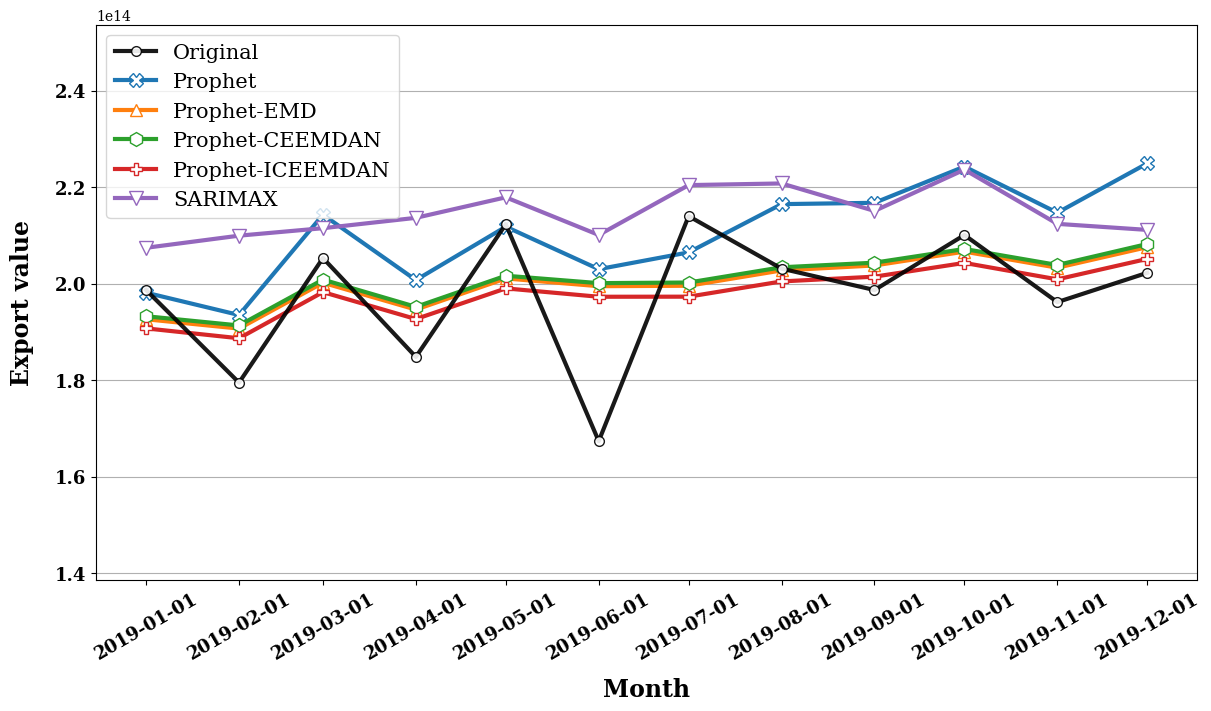

In [ ]:
plotting_test(exp_df, exp_df_p, exp_df_ep, exp_df_cp,exp_df_icp, exp_df_s, "Export value", "Month", "exp_test_func.jpg",12)

### bar plot

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] += ['Times Roman']
width = 0.1

def bar_plotter(values, title, name, tick):
  xticks = ['MAPE']
  multiplier = 0
  x = np.arange(len(xticks))

  fig, ax = plt.subplots(layout="constrained", figsize=(10,6))

  for i,j in values.items():
    offset = width * multiplier
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] += ['Times Roman']
    rects = ax.bar(x + offset, j, width, label = i)
    ax.bar_label(rects, padding=4, fontweight="bold", fontsize=13)
    multiplier+=1

  plt.legend(fontsize=13, loc="upper left")

  ax.set_xticks(x+tick, xticks, fontsize=14, fontweight="bold")
  plt.yticks(fontweight='bold', fontsize=14)

  ceil = round(max(list(values.values())) + 0.2*(max(list(values.values()))))

  plt.ylim(0, ceil)

  plt.grid(axis='y')
  ax.set_axisbelow(True)
  plt.margins(2*(1-len(values)/10), 0)
  plt.savefig(f"{name}.jpg", dpi=1200)

round


In [ ]:
def rounder(dictionary):
  for i,j in dictionary.items():
    dictionary[i] = round(j, 2)
  return(dictionary)

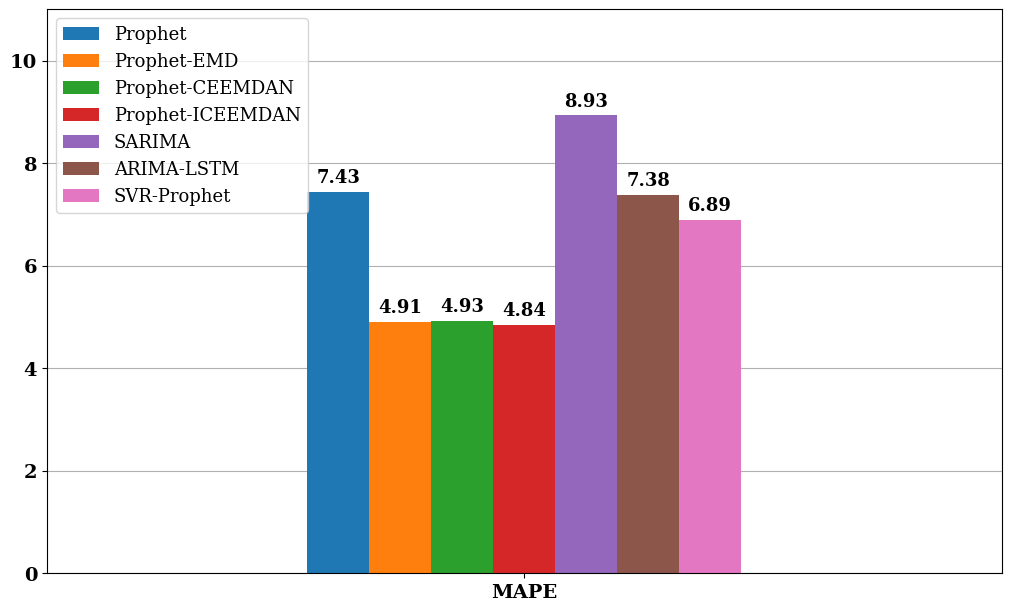

In [ ]:
export_values = {
    # method : (MAPE)
    "Prophet":(7.43),
    "Prophet-EMD": (4.91),
    "Prophet-CEEMDAN":(4.93),
    "Prophet-ICEEMDAN":(4.837),
    "SARIMA":(8.93),
    "ARIMA-LSTM " : (7.38),
    "SVR-Prophet" : (6.89)
}

bar_plotter(rounder(export_values), "Indonesian export evaluation", "Export_comparison_bar",0.3)